Initialise code for google colab

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [ ]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa
print(tfa.__version__)

2.11.0
0.19.0


In [2]:
!pip install tensorflow==2.11
!pip install tensorflow-addons==0.19

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 588.3/588.3 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.2/439.2 KB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.0/6.0 MB 121.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.2 MB/s eta 0:00:00
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 1.12
    Uninstalling flatbuffers-1.12:
      Successfully uninstalled flatbuffers-1.12
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: tensorboard
    Found existing 

Create data base files under google colab environment

In [1]:
!unzip -q '/content/drive/MyDrive/data_equalize.zip' -d '/content/'

Define working directory to our jupyter repertory:
* because path to the different repertories (./data, ./output...) are define relatevly to jupyter one
* let import _mypath which add ./lib to python path in order to import our own define libraries


In [2]:
# for google colab use
%cd /content/drive/MyDrive/covid-19-xRay/jupyter
from google.colab.patches import cv2_imshow
db_work_dir = '/content'


/content/drive/MyDrive/covid-19-xRay/jupyter


In [ ]:
# for local use
db_work_dir = '..'

In [3]:
import _mypath
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import cv2
from PIL import Image

%load_ext autoreload
%autoreload 1

In [4]:
%aimport database.path_origin_data
%aimport database.dataset

from database.path_origin_data import build_data_paths 
from database.path_origin_data import lung_name, infection_name
from database.path_origin_data import train_name, test_name, valid_name
from database.path_origin_data import normal_name, covid_name, no_covid_name
from database.path_origin_data import images_name, lung_mask_name, infection_mask_name

from database.dataset import build_dataset

%aimport run_exp.test

from run_exp.test import compile_test_model

%aimport visu.pattern
%aimport visu.occultation
%aimport visu.grad_cam
%aimport visu.plots

from visu.pattern import build_pattern_list
from visu.occultation import occultation_list
from visu.grad_cam import grad_cam_list
from visu.plots import plot_image_list



Build paths and variables for reading data base hierarchy

In [5]:
# input
db_name = 'data_equalize'
db_path = os.path.join(db_work_dir, db_name)

# output
output_path = os.path.join('..', 'output', 'cnn_transformer')
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

log_path = os.path.join(output_path, 'log')
if not os.path.exists(log_path):
    os.makedirs(log_path, exist_ok=True)

ckpt_path = os.path.join(output_path, 'ckpt')
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path, exist_ok=True)

metric_path = os.path.join(output_path, 'metric')
if not os.path.exists(metric_path):
    os.makedirs(metric_path, exist_ok=True)


activation_path = os.path.join(output_path, 'activation')
if not os.path.exists(activation_path):
    os.makedirs(activation_path, exist_ok=True)

pattern_path = os.path.join(output_path, 'pattern')
if not os.path.exists(pattern_path):
    os.makedirs(pattern_path, exist_ok=True)

occultation_path = os.path.join(output_path, 'occulatation')
if not os.path.exists(occultation_path):
    os.makedirs(occultation_path, exist_ok=True)

grad_cam_path = os.path.join(output_path, 'grad_cam')
if not os.path.exists(grad_cam_path):
    os.makedirs(grad_cam_path, exist_ok=True)


Learning curves

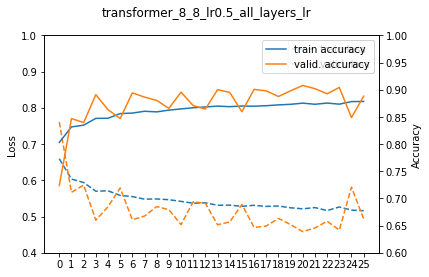

In [ ]:
# nn_name = 'cnn'
# nn_name = 'pure_cnn_lr0.001'
# nn_name = 'transformer_8_8_lr0.5'
nn_name = 'transformer_8_8_lr0.5_all_layers_lr'
# nn_name = 'transformer_8_8_lr0.5_all_layers_lr_fine_tuning_lr0.0001'

learning_df = pd.read_csv(os.path.join(log_path, nn_name + '_log.csv'))
# print(learning_df.head(25))

fig, ax1 = plt.subplots()
fig.suptitle(nn_name)

epoch = learning_df['epoch']

ax1.set_ylim(0.4, 1.)
ax1.set_ylabel("Loss")
ax1.plot(epoch, learning_df['loss'], '--', label='train loss')
ax1.plot(epoch, learning_df['val_loss'], '--', label='valid. loss')
ax1.legend()

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(epoch)
ax2.set_xlabel("Num epoch")
ax2.set_ylim(0.6, 1.)
ax2.set_ylabel("Accuracy")
ax2.plot(epoch, learning_df['accuracy'], label='train accuracy')
ax2.plot(epoch, learning_df['val_accuracy'], label='valid. accuracy')
ax2.legend()

plt.savefig(os.path.join(metric_path, nn_name + '_learning_curves.png'), format='png')
plt.show()


Structure to manage paths in data base

In [6]:
data_paths = build_data_paths()
idx = pd.IndexSlice

Model parameters

In [7]:
image_size = 256
input_shape = (image_size, image_size, 1)

# data augmentation
scale = 1. / 255.
flip = "horizontal"
rotation_factor = 10. / 360.
zoom_height_factor = 0.2
zoom_width_factor = 0.2

# vit
patch_size = 1
transformer_layers = 4
num_heads = 8
projection_dim = 64
transformer_units_rate = [2, 1]
mlp_head_units = [1024, 256]  # Size of the dense layers of the final classifier


Data augmentation

In [8]:
augmentation = keras.Sequential(
    [
      layers.Rescaling(scale=scale),
      layers.RandomFlip(flip),
      layers.RandomRotation(rotation_factor),
      layers.RandomZoom(height_factor=zoom_height_factor, width_factor=zoom_width_factor),
    ],
    name='augmentation'
)

cnn encoder

In [9]:
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dropout

encoder = keras.Sequential(
    [
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(128, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Conv2D(64, (3, 3), activation = 'relu', padding='same', kernel_initializer='random_normal'),
      layers.MaxPooling2D(pool_size = (2, 2)),
      layers.Flatten(),
    ],
    name='encoder'
)

Build model

In [10]:
shared_encoder = keras.Sequential(name='shared_encoder')
for layer in encoder.layers[:-1]:
  shared_encoder.add(layer)

In [11]:
%aimport myLayers.vision_transformer
%aimport myLayers.mlp
from myLayers.vision_transformer import add_vit
from myLayers.mlp import mlp

inputs = layers.Input(shape=input_shape)
augmented = augmentation(inputs)
shared_encoded = shared_encoder(augmented)
features = add_vit(shared_encoded,
            patch_size=patch_size,
            input_image_size=shared_encoded.shape[1],
            transformer_layers=transformer_layers,
            num_heads=num_heads,
            projection_dim=projection_dim,
            transformer_units_rate=transformer_units_rate,
            mlp_head_units=mlp_head_units)
# Classify outputs.
softmax = layers.Dense(3, activation='softmax', kernel_initializer='random_normal')(features)

# Create the Keras model
model = keras.Model(inputs=inputs, outputs=softmax)
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 1  0           []                               
                                )]                                                                
                                                                                                  
 augmentation (Sequential)      (None, 256, 256, 1)  0           ['input_1[0][0]']                
                                                                                                  
 shared_encoder (Sequential)    (None, 8, 8, 64)     296512      ['augmentation[0][0]']           
                                                                                                  
 patches (Patches)              (None, None, 64)     0           ['shared_encoder[0][0]']     

In [12]:
checkpoint_filename = os.path.join(ckpt_path, 'transformer_8_8_lr0.5_all_layers_lr_fine_tuning_lr0.0001_weights.hdf5')
model.load_weights(checkpoint_filename)

encoder_name = 'shared_encoder'
model.get_layer(encoder_name).summary()

Model: "shared_encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 256, 256, 128)     1280      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 128, 128, 128)    0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 128)     147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 64, 64, 128)      0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 64, 64, 64)        73792     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 32, 32, 64)    

In [22]:
def extract_conv_model(model, layer_index, encoder_name='shared_encoder'):
  encoder_index = 0
  for i, layer in enumerate(model.layers):
    if layer.name == encoder_name:
      encoder_index = i
      break
  # print(encoder_index)

  pre_model = keras.Model(model.input, model.layers[encoder_index-1].get_output_at(0))
  eff_net = keras.Model(model.layers[encoder_index].layers[0].input, model.layers[encoder_index].layers[layer_index].get_output_at(0))
  until_conv_model = keras.Model(pre_model.input, eff_net.call(pre_model.output))
  return until_conv_model


In [ ]:
path = data_paths['path'].loc[idx[[lung_name], [test_name], [normal_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_normal = os.listdir(image_path)
list_file_name_normal = [os.path.join(image_path, file_name) for file_name in list_file_name_normal]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_covid = os.listdir(image_path)
list_file_name_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_covid]

path = data_paths['path'].loc[idx[[lung_name], [test_name], [no_covid_name], [images_name]]][0]
image_path = os.path.join(db_path, path)
list_file_name_no_covid = os.listdir(image_path)
list_file_name_no_covid = [os.path.join(image_path, file_name) for file_name in list_file_name_no_covid]


In [ ]:
# list_file_name = list_file_name_normal
# image_label = 'normal'
list_file_name = list_file_name_covid
image_label = 'covid'
# list_file_name = list_file_name_no_covid
# image_label = 'no-covid'

image_file_name = list_file_name[100]
image_file_name

'/content/data_equalize/Lung Segmentation Data/Test/COVID-19/images/sub-S09457_ses-E18156_run-1_bp-chest_vp-ap_dx.png'

Visualization of activation in conv layer

In [ ]:
model_shared_encoder_4 = extract_conv_model(model, 4, encoder_name=encoder_name)

# Load image
img = keras.preprocessing.image.load_img(
    image_file_name,
    target_size=(image_size, image_size),
    grayscale=True)
img = keras.preprocessing.image.img_to_array(img)

# Get the outputs of layers we want to inspect
outputs = [model_shared_encoder_4.output]

# Create a connection between the input and those target outputs
activations_model = keras.Model(model.input, outputs=outputs)
activations_model.compile(optimizer='adam', loss='categorical_crossentropy')

# Get their outputs
activations = activations_model.predict(np.array([img]))[0]

/usr/local/lib/python3.8/dist-packages/keras/utils/image_utils.py:409: UserWarning: grayscale is deprecated. Please use color_mode = "grayscale"
  warnings.warn(


1/1 [==============================] - 0s 282ms/step


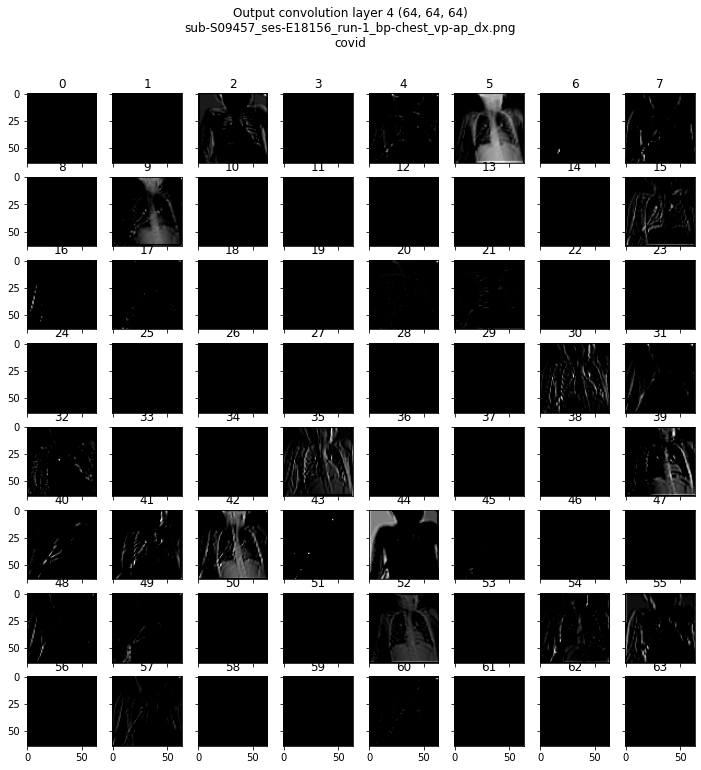

In [ ]:
nrows = 8
ncols = 8
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(12, 12))
num_filer = min(nrows*ncols, activations.shape[-1])
for i in range(num_filer):
    image = activations[:, :, i]   
    ax.flatten()[i].imshow(image, cmap='gray')
    ax.flatten()[i].set_title(str(i))

base_name = os.path.basename(image_file_name)
fig.suptitle('Output convolution layer 4 (64, 64, 64)\n' + base_name + '\n' + image_label)
plt.savefig(os.path.join(activation_path, 'activation_' + base_name + '_' + image_label + '.png'), format='png')
plt.show()


In [ ]:
conv_layers = tf.keras.Sequential(name='conv_layer')
# conv_layer_index = 0
# nb_filters = 128
# pattern_size = 3

# conv_layer_index = 2
# nb_filters = 128
# pattern_size = 7

# conv_layer_index = 4
# nb_filters = 64
# pattern_size = 13

conv_layer_index = 6
nb_filters = 64
pattern_size = 25

for layer in shared_encoder.layers[:conv_layer_index+1]:
  conv_layers.add(layer)

inputs_pattern_size = layers.Input(shape=(pattern_size, pattern_size, 1))
# augmented_input_pattern_size = augmentation(inputs_pattern_size)
conv_layers_input_pattern_size = conv_layers(inputs_pattern_size)

model_conv_layers_input_pattern_size = keras.Model(
    inputs=inputs_pattern_size,
    outputs=conv_layers_input_pattern_size
)
model_conv_layers_input_pattern_size.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 25, 25, 1)]       0         
                                                                 
 conv_layer (Sequential)     (None, 3, 3, 64)          259584    
                                                                 
Total params: 259,584
Trainable params: 259,584
Non-trainable params: 0
_________________________________________________________________


In [ ]:
epochs = 100
step_size = 1.

pattern_list = build_pattern_list(
  model_conv_layers_input_pattern_size,
  pattern_size, nb_filters,
  epochs=epochs, step_size=step_size
)


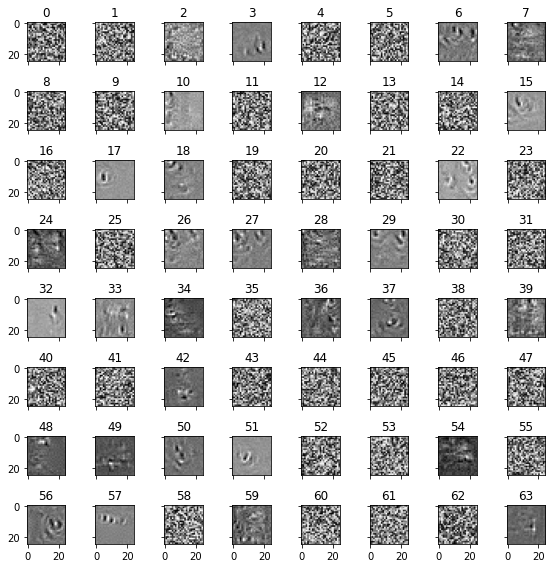

In [ ]:
nrows = 8
ncols = nb_filters // nrows
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(ncols, nrows))

num_filer = min(nrows*ncols, len(pattern_list))
for i in range(num_filer):
    image = pattern_list[i]
    ax.flatten()[i].imshow(np.squeeze(image), cmap='gray')
    ax.flatten()[i].set_title(str(i))

# fig.suptitle('Pattern convolution layer ' + str(conv_layer_index))
fig.tight_layout()
plt.savefig(os.path.join(pattern_path, 'pattern_conv_layer_' + str(conv_layer_index) + '.png'), format='png')
plt.show()


In [ ]:
# image_file_name = list_file_name[100]
# image_file_name = list_file_name[762]
# image_file_name = list_file_name[960]

ind = [i for i, f in enumerate(list_file_name) if 'S12816_ses-E27025_run-1_bp-chest_vp-pa_cr' in f]
print(ind)
image_file_name = list_file_name[ind[0]]


[1423]


In [ ]:
occ = occultation_list(
    [image_file_name], model,
    image_size=image_size, patch_size=32,
    sub_samp_for_step=4, pred_index=None
)[0]


0:0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,


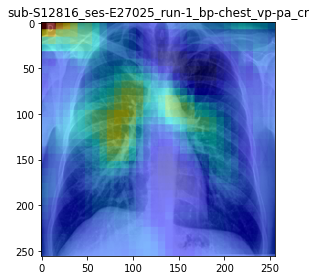

In [ ]:
occ_RGB = cv2.cvtColor(occ, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(occ_RGB)

fig, ax = plt.subplots()
ax.imshow(im_pil)
f_name = os.path.splitext(os.path.basename(image_file_name))[0]
ax.set_title(f_name)
fig.tight_layout()

plt.savefig(os.path.join(occultation_path, 'occultation_' + f_name + '_' + image_label + '.png'), format='png')
plt.show()


In [ ]:
from random import sample

nrows = 8
ncols = 8
num_img = nrows * ncols

samples = list_file_name
if (len(samples) >= num_img):
  samples = sample(samples, num_img)


In [ ]:
occ_list = occultation_list(
    samples, model,
    image_size=image_size, patch_size=32,
    sub_samp_for_step=4, pred_index=None
)

In [ ]:
fig_title = 'Occultation ' + image_label
fig_file_name = 'occultation_' + image_label
plot_image_list(
    occ_list, nrows, ncols,
    fig_title, fig_file_name,
    occultation_path
)

In [23]:
output_conv_layer = model.get_layer(encoder_name).get_output_at(0)
resize_shape = None
# output_conv_layer = model_transformer.get_layer('layer_normalization_8').get_output_at(0)
# resize_shape = (8, 8)

grad_model = keras.Model(
  [model.input],
  [output_conv_layer, model.output])


In [ ]:
cam = grad_cam_list(
  [image_file_name], grad_model,
  image_size=image_size, resize_shape=resize_shape,
  pred_index=None
)[0]

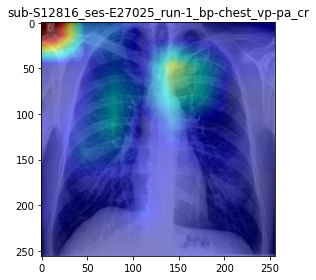

In [ ]:
cam_RGB = cv2.cvtColor(cam, cv2.COLOR_BGR2RGB)
im_pil = Image.fromarray(cam_RGB)

fig, ax = plt.subplots()
ax.imshow(im_pil)
f_name = os.path.splitext(os.path.basename(image_file_name))[0]
ax.set_title(f_name)
fig.tight_layout()

plt.savefig(os.path.join(grad_cam_path, 'grad_cam_' + f_name + '_' + image_label + '.png'), format='png')
plt.show()

In [ ]:
cam_list = grad_cam_list(
  samples, grad_model,
  image_size=image_size, resize_shape=resize_shape,
  pred_index=None
)

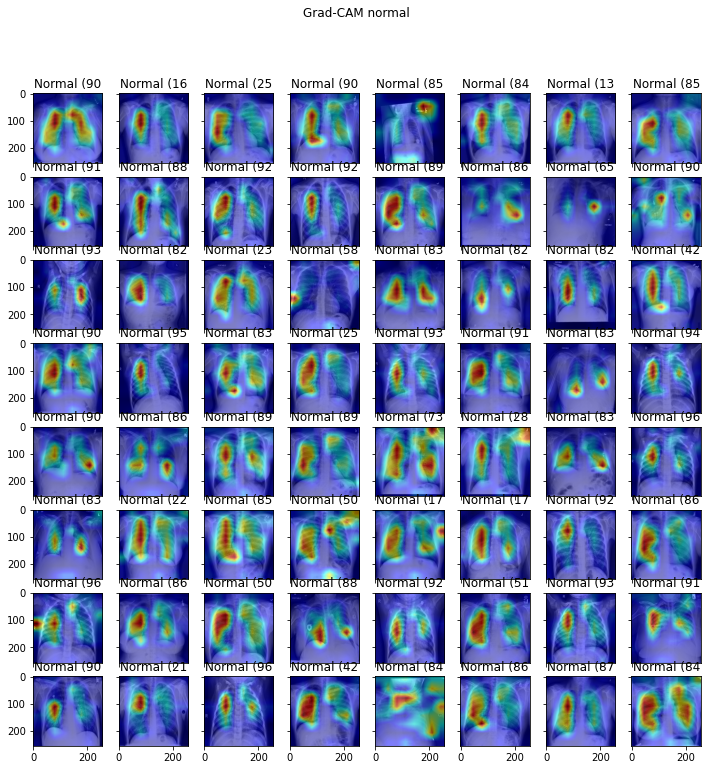

In [ ]:
fig_title = 'Grad-CAM ' + image_label
fig_file_name = 'grad_cam_' + image_label
plot_image_list(
    cam_list, nrows, ncols,
    fig_title, fig_file_name,
    grad_cam_path
)


Predicted results visualization

Create tf Dataset

In [13]:
paths = data_paths['path']

ds_train, ds_train_file_paths = build_dataset(db_path, paths, db=[lung_name], ds=[train_name])
ds_test, ds_test_file_paths = build_dataset(db_path, paths, db=[lung_name], ds=[test_name])
ds_valid, ds_valid_file_paths = build_dataset(db_path, paths, db=[lung_name], ds=[valid_name])
print(ds_train.cardinality().numpy())
print(len(ds_train_file_paths))

Found 6849 files belonging to 1 classes.
Found 7658 files belonging to 1 classes.
Found 7208 files belonging to 1 classes.
Found 2140 files belonging to 1 classes.
Found 2394 files belonging to 1 classes.
Found 2253 files belonging to 1 classes.
Found 1712 files belonging to 1 classes.
Found 1902 files belonging to 1 classes.
Found 1802 files belonging to 1 classes.
21715
21715


In [14]:
# test_accuracy(
#     model_transformer,
#     ds_train, batch_size_transformer,
# )
# test_accuracy(
#     model_transformer,
#     ds_valid, batch_size_transformer,
# )
# test_accuracy(
#     model_transformer,
#     ds_test, batch_size_transformer,
# )

model_conf_mat, y_test_pd, y_pred_pd = compile_test_model(
    model,
    ds_test, 32,
    from_logits=False, label_smoothing=0.1
)
model_conf_mat

213/213 [==============================] - 26s 69ms/step - loss: 0.4454 - accuracy: 0.9334
Test accuracy: 93.34%
213/213 [==============================] - 14s 59ms/step


Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


              precision    recall  f1-score   support

           0       0.94      0.89      0.92      2140
           1       0.98      0.96      0.97      2394
           2       0.88      0.95      0.91      2253

    accuracy                           0.93      6787
   macro avg       0.93      0.93      0.93      6787
weighted avg       0.93      0.93      0.93      6787



Predicted,0,1,2
Real,,,
0,1907,23,210
1,32,2294,68
2,87,32,2134


In [15]:
file_paths_pd = pd.DataFrame(data=ds_test_file_paths, columns=['file_path'])
results_pd = pd.concat(
    [file_paths_pd,
     y_test_pd.to_frame('real'),
     y_pred_pd.to_frame('predicted')
    ],
    axis=1,
)
results_pd.head()

,file_path,real,predicted
0,/content/data_equalize/Lung Segmentation Data/...,0,0
1,/content/data_equalize/Lung Segmentation Data/...,0,0
2,/content/data_equalize/Lung Segmentation Data/...,0,0
3,/content/data_equalize/Lung Segmentation Data/...,0,0
4,/content/data_equalize/Lung Segmentation Data/...,0,0


In [34]:
# fig_selected = results_pd[results_pd['real'] != results_pd['predicted']]
# fig_title = 'False detection'
# fig_file_name = 'false_detection'

fig_selected = results_pd[results_pd['real'] == results_pd['predicted']]
fig_title = 'True detection'
fig_file_name = 'true_detection'

# fig_selected = results_pd[results_pd['real'] != results_pd['predicted']]
# fig_selected = fig_selected[fig_selected['real'] == 1]
# fig_title = 'False Covid detection'
# fig_file_name = 'false_covid_detection'

fig_selected.head()

,file_path,real,predicted
0,/content/data_equalize/Lung Segmentation Data/...,0,0
1,/content/data_equalize/Lung Segmentation Data/...,0,0
2,/content/data_equalize/Lung Segmentation Data/...,0,0
3,/content/data_equalize/Lung Segmentation Data/...,0,0
4,/content/data_equalize/Lung Segmentation Data/...,0,0


In [35]:
n = len(fig_selected)
nrows = 8
ncols = 8
num_img = nrows * ncols
samples = fig_selected['file_path']
if num_img < len(samples):
    samples = samples.sample(n=num_img, replace=False)


In [36]:
cam_list = grad_cam_list(
  samples, grad_model,
  image_size=image_size, resize_shape=resize_shape,
  pred_index=None
)

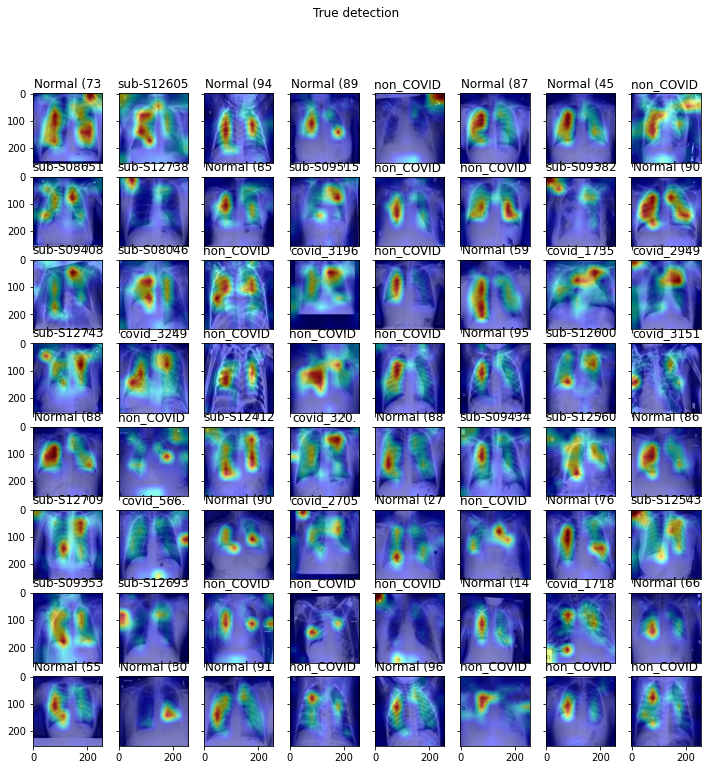

In [37]:
plot_image_list(
    cam_list, nrows, ncols,
    fig_title, fig_file_name,
    grad_cam_path
)